# Variable Selection

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.ensemble import BaggingRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def run_model(model, X, y, num_iterations):
    rmse_scores = []
    r2_scores = []
    rand_state = np.random.randint(0, num_iterations*10, num_iterations)
    for i in rand_state:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=i)
        my_model = model.fit(X_train, y_train)
        pred = my_model.predict(X_test)
        r2_scores.append(my_model.score(X_test, y_test))
        rmse_scores.append(rmse(pred, y_test))
    scores = list(zip(rand_state, rmse_scores, r2_scores))
    sorted_scores = sorted(scores, key=lambda x: x[1])
    return sorted_scores, rmse_scores, r2_scores

In [3]:
def rmse(pred, y):
    n = len(y)
    RMSE = np.sqrt(sum((pred - y)**2) / n)
    return RMSE

In [13]:
reduced_ot = pd.read_csv("../reduced.csv")
reduced_ot = reduced_ot.drop(columns = "Unnamed: 0")

In [15]:
no_ot = np.array(reduced_ot)
good_games = list()
for game in no_ot:
    if game[13] == 0:
        good_games.append(game)
reduced_noot = pd.DataFrame(good_games, columns=reduced_ot.columns)
reduced_noot = reduced_noot.drop(columns="ot")

In [17]:
X = reduced_noot.drop(columns="scores")
y = reduced_noot["scores"]**2

In [19]:
lr = LinearRegression()
X_1 = reduced_noot.drop(columns=["scores", "int_pct", "sack_pct", "sack_yd_pct", "fum_pct"])
X_2 = reduced_noot.drop(columns=["scores", "sack_pct", "sack_yd_pct", "fum_pct"])
var_list = [X, X_1, X_2]

In [20]:
scores = list()
min_rmse = list()
avg_rmse = list()
max_rmse = list()
min_r2 = list()
avg_r2 = list()
max_r2 = list()
for i in range(len(var_list)):
    scs, rmse_sc, r2_sc = run_model(lr, var_list[i], y, 1000)
    scores.append((i, scs[0]))
    min_rmse.append((i, round(min(rmse_sc), 3)))
    max_rmse.append((i, round(max(rmse_sc), 3)))
    avg_rmse.append((i, round(np.mean(rmse_sc), 3)))
    min_r2.append((i, round(min(r2_sc), 3)))
    max_r2.append((i, round(max(r2_sc), 3)))
    avg_r2.append((i, round(np.mean(r2_sc), 3)))

In [21]:
gathered = list()
for i in range(len(avg_rmse)):
    gathered.append((i, avg_rmse[i][1], min_rmse[i][1], max_rmse[i][1], 
                     avg_r2[i][1], min_r2[i][1], max_r2[i][1]))
gathered_sorted = sorted(gathered, key=lambda sc: sc[1])

In [22]:
summary = pd.DataFrame(gathered_sorted, columns=["Var", "Average RMSE", "Min RMSE", "Max RMSE",
                                                 "Average R^2", "Min R^2", "Max R^2"])
summary

,Var,Average RMSE,Min RMSE,Max RMSE,Average R^2,Min R^2,Max R^2
0,1,6.759,6.269,7.309,0.578,0.506,0.647
1,0,6.765,6.154,7.301,0.576,0.483,0.642
2,2,6.769,6.077,7.337,0.577,0.485,0.652


In [31]:
var = var_list[gathered_sorted[0][0]]
lin_reg = LinearRegression()
bag = BaggingRegressor(lin_reg, bootstrap=True, n_estimators=60, max_samples=0.95)
bag_scores, bag_rmse, bag_r2 = run_model(bag, var, y, 10)

In [32]:
bag_gathered = [(gathered_sorted[0][0], np.mean(bag_rmse), min(bag_rmse), max(bag_rmse), 
                np.mean(bag_r2), min(bag_r2), max(bag_r2))]

In [33]:
bag_summary = pd.DataFrame(bag_gathered, columns=["Var", "Average RMSE", "Min RMSE", "Max RMSE", 
                                                  "Average R^2", "Min R^2", "Max R^2"])
bag_summary

,Var,Average RMSE,Min RMSE,Max RMSE,Average R^2,Min R^2,Max R^2
0,1,6.700494,6.387782,6.927017,0.583955,0.560516,0.61517


# Cross Validation Visualization

In [26]:
train_size, train_scores, valid_scores = learning_curve(estimator=bag, X=t_X_train, y=t_y_train, 
                                                        train_sizes=np.arange(0.75, 1.0, 0.01), cv=10, 
                                                        n_jobs=-1)

In [27]:
train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)

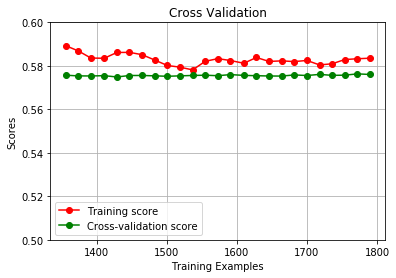

In [28]:
plt.figure()
plt.title("Cross Validation")
plt.xlabel("Training Examples")
plt.ylabel("Scores")
plt.grid()
plt.plot(train_size, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_size, valid_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.ylim(0.5, 0.6)
plot = plt.legend(loc="best")

# Grid Search over Bagging Regressor

In [29]:
bag_search = {"n_estimators":np.arange(58, 63, 1), "max_samples":np.arange(0.9, 0.96, 0.01)}

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=0.25)

In [35]:
bagger = BaggingRegressor(lin_reg, bootstrap=True)
bag_gs = GridSearchCV(bagger, bag_search, cv=20, n_jobs=-1)

In [42]:
bag_gs.fit(X_train, y_train)

GridSearchCV(cv=20, error_score='raise-deprecating',
       estimator=BaggingRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': array([58, 59, 60, 61, 62]), 'max_samples': array([0.9 , 0.91, 0.92, 0.93, 0.94, 0.95])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [43]:
bag_gs.best_params_

{'max_samples': 0.91, 'n_estimators': 59}

# Final Model

I think var_1 or var_2 gives the most consistent results. Use above hyperparameters, approximately n_estimators = 59 and max_samples = 0.92.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=0.25)

In [45]:
final_bag = BaggingRegressor(LinearRegression(), n_estimators=59, max_samples=0.92, 
                             bootstrap=True, n_jobs=-1)
final_bag.fit(X_train, y_train)

BaggingRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.92, n_estimators=59, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [47]:
all_coefs = []
for coef in range(len(final_bag.estimators_[0].coef_)):
    all_coefs.append(list())
for est in final_bag.estimators_:
    for coef in range(len(est.coef_)):
        all_coefs[coef].append(est.coef_[coef])
avg_coefs = [np.mean(c) for c in all_coefs]
coefs = X_1.columns
list(zip(coefs, avg_coefs))

[('predscores', 0.5141420728179772),
 ('tmhalfsc', 0.9254361020025723),
 ('opphalfsc', 0.0306522656594796),
 ('patt', 0.0995549599301426),
 ('ypa', 0.13675292277676776),
 ('comppct', 0.4005551980515321),
 ('ratt', -0.005367557528968067),
 ('ypr', 0.2355110171172852)]

In [48]:
bag_pred = final_bag.predict(X_test)
for s in range(len(bag_pred)):
    bag_pred[s] = round(bag_pred[s], 2)
bag_rmse = rmse(bag_pred, y_test)
bag_r2 = final_bag.score(X_test, y_test)

In [49]:
print(f"Final RMSE: {bag_rmse:.4f}")
print(f"Final R^2: {bag_r2:.4f}")

Final RMSE: 6.6564
Final R^2: 0.5908


In [50]:
resids = y_test - bag_pred

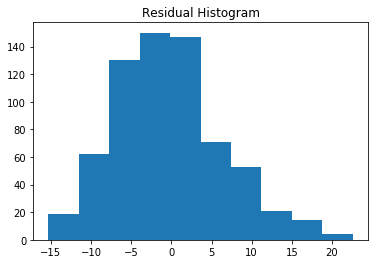

In [51]:
plt.hist(resids)
plt.title("Residual Histogram")
plt.show()

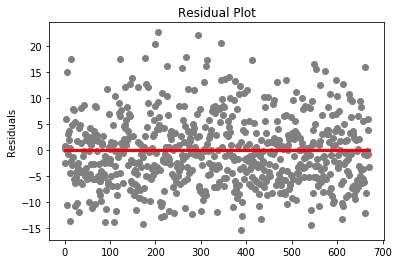

In [52]:
plt.scatter(range(len(resids)), resids, color="grey")
plt.plot(range(len(resids)), np.zeros(len(resids)), color="red", linewidth=3)
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()